In [ ]:
#Developed with ideas generated from various examples online
#Certain aspects generated with help from chatGPT

## Import Libraries

In [2]:
# Importing necessary libraries
import numpy as np
import os
import random
import cv2
import imghdr
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Declare directories

In [3]:
# Define data directories
training_dir = '/kaggle/input/brain-tumor-classification-latest/Brain Tumor Classification_Latest/Training'
testing_dir = '/kaggle/input/brain-tumor-classification-latest/Brain Tumor Classification_Latest/Testing'
validation_dir ='/kaggle/input/brain-tumor-classification-latest/Brain Tumor Classification_Latest/Validation'
os.listdir(training_dir)

['meningioma', 'no_tumor', 'glioma', 'pituitary']

In [4]:
#data directory
data = tf.keras.utils.image_dataset_from_directory(training_dir)

Found 10039 files belonging to 4 classes.


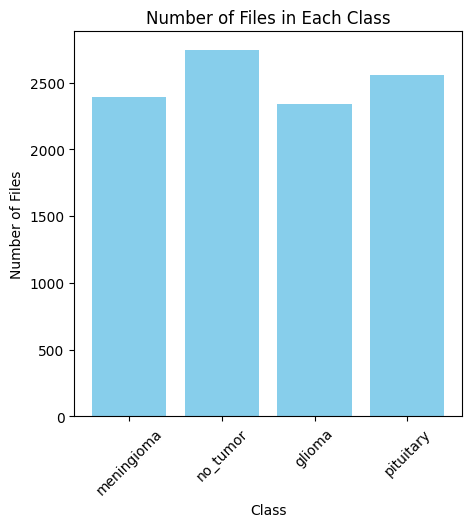

In [5]:
classes = os.listdir(training_dir)

# Count the number of files in each class
file_counts = {}
for class_name in classes:
    class_dir = os.path.join(training_dir, class_name)
    num_files = len(os.listdir(class_dir))
    file_counts[class_name] = num_files

# Plot the number of files in each class
plt.figure(figsize=(5, 5))
plt.bar(file_counts.keys(), file_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class')
plt.xticks(rotation=45)
plt.show()


## Preprocessing data and augmenting on the go

In [6]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Define image parameters
img_height, img_width = 256, 256
batch_size = 256 ##batch size was 128 prior to 256

In [8]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10039 images belonging to 4 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2785 images belonging to 4 classes.


In [10]:
# Generate an augmented image
img = plt.imread('/kaggle/input/brain-tumor-classification-latest/Brain Tumor Classification_Latest/Training/glioma/aug_0_10.jpg')  # Load an example image
img = img.reshape((1,) + img.shape)  # Reshape image to (1, height, width, channels) for generator
aug_iter = train_datagen.flow(img, batch_size=1)

# Get augmented image
augmented_img = next(aug_iter)[0]

# Check the maximum pixel value
max_pixel_value = np.max(augmented_img)
print("Maximum pixel value after augmentation:", max_pixel_value)

# Check the minimum pixel value
min_pixel_value = np.min(augmented_img)
print("Minimum pixel value after augmentation:", min_pixel_value)

Maximum pixel value after augmentation: 0.9803922
Minimum pixel value after augmentation: 0.0


## CNN Model with L2 regularization and batchnormalization

In [11]:
model = Sequential()
#Input
#Input = 256x256x3
model.add(Input(shape=(256, 256, 3)))
#Block 1
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.25)) #Dropout rate of 0.25
#Block 2
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.25)) #Dropout rate of 0.25
#Block 3
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.25)) #Dropout rate of 0.25

#Fully Connected layer
#Flattening Layre
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      6416      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      6416      
                                                        

In [12]:
# Compile the model
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/30
39/39 [==============================] - 89s 1s/step - loss: 1.7185 - accuracy: 0.4313 - val_loss: 1.1347 - val_accuracy: 0.6234
Epoch 2/30
39/39 [==============================] - 47s 1s/step - loss: 1.0663 - accuracy: 0.6411 - val_loss: 0.9512 - val_accuracy: 0.7195
Epoch 3/30
39/39 [==============================] - 46s 1s/step - loss: 0.8993 - accuracy: 0.7219 - val_loss: 0.8390 - val_accuracy: 0.7473
Epoch 4/30
39/39 [==============================] - 48s 1s/step - loss: 0.8097 - accuracy: 0.7734 - val_loss: 0.8525 - val_accuracy: 0.7617
Epoch 5/30
39/39 [==============================] - 46s 1s/step - loss: 0.7615 - accuracy: 0.8018 - val_loss: 0.7407 - val_accuracy: 0.8211
Epoch 6/30
39/39 [==============================] - 48s 1s/step - loss: 0.7220 - accuracy: 0.8154 - val_loss: 0.6266 - val_accuracy: 0.8551
Epoch 7/30
39/39 [==============================] - 46s 1s/step - loss: 0.6327 - accuracy: 0.8407 - val_loss: 0.6548 - val_accuracy: 0.8328
Epoch 8/30
39/39 [==

In [14]:
# Evaluate the model
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1113 images belonging to 4 classes.


5/5 [==============================] - 7s 2s/step


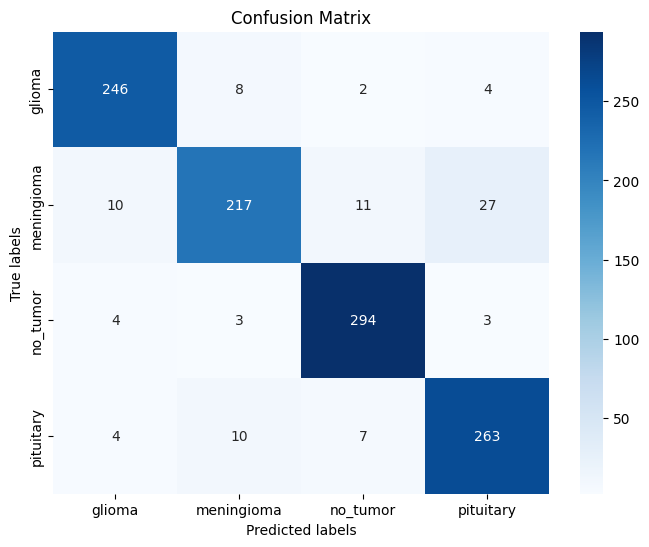

In [15]:
#Generated with some help from chatGPT
#Generate predictions for the test dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels into class indices
true_classes = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       260
           1       0.91      0.82      0.86       265
           2       0.94      0.97      0.95       304
           3       0.89      0.93      0.91       284

    accuracy                           0.92      1113
   macro avg       0.92      0.91      0.91      1113
weighted avg       0.92      0.92      0.92      1113



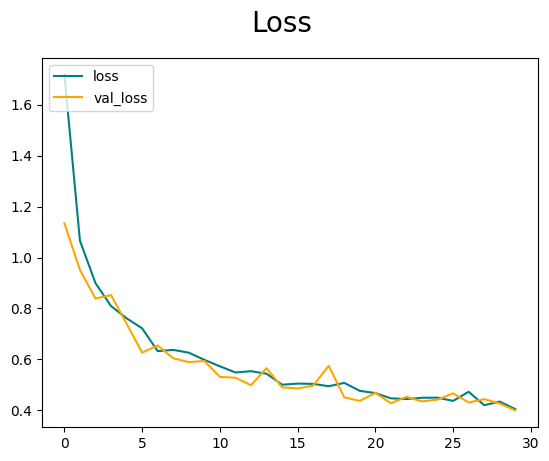

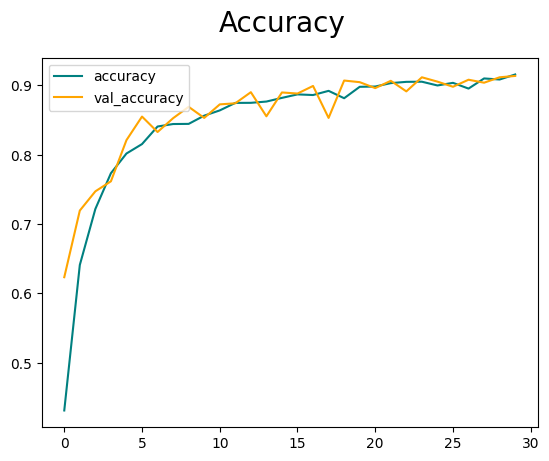

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

5/5 [==============================] - 3s 604ms/step - loss: 0.4189 - accuracy: 0.9164
Test Accuracy: 0.9164420366287231


1/1 [==============================] - 0s 26ms/step


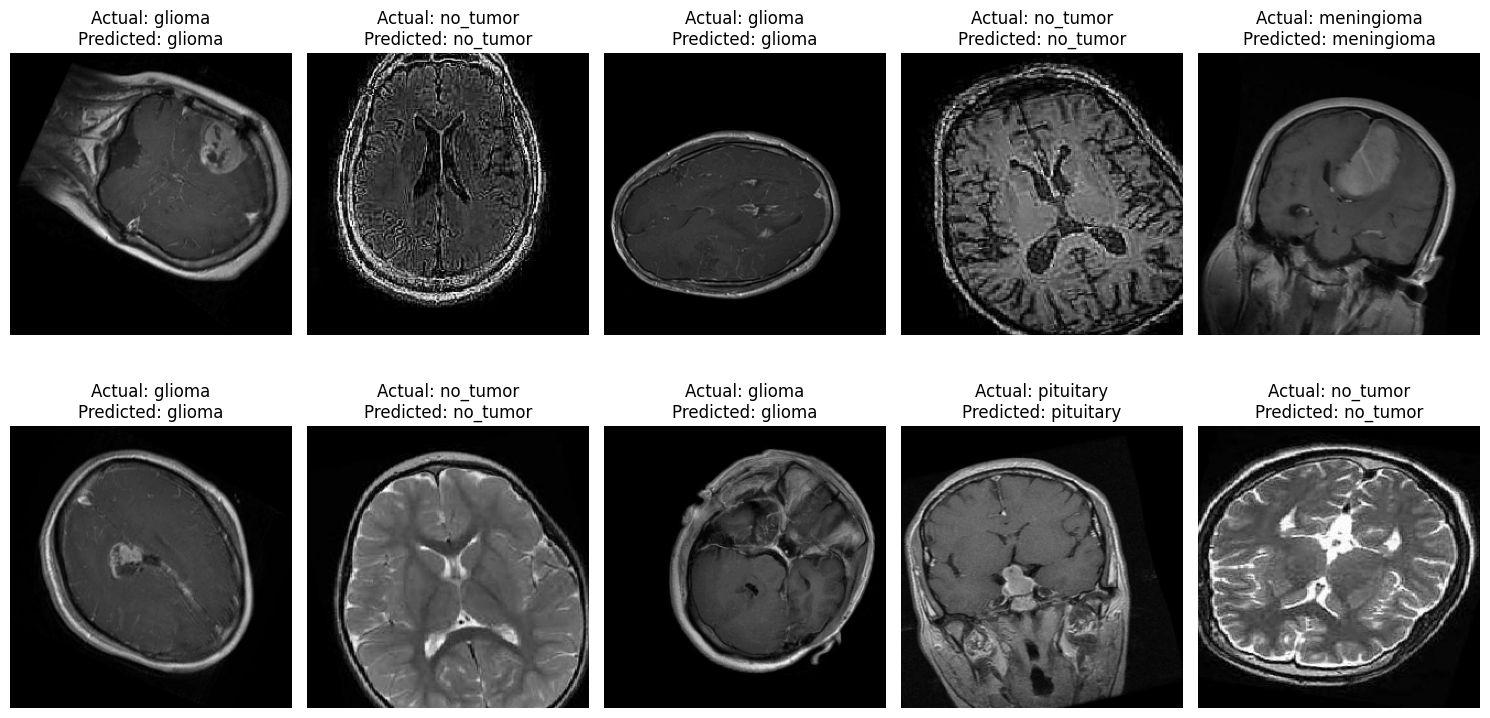

In [19]:
#Generated with some help form chatGPT
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define class labels and other necessary variables
class_labels = sorted(os.listdir(training_dir))
num_images = 10  # Number of images to predict

# Function to randomly select a file from the test folder
def select_random_file(testing_dir):
    class_name = random.choice(class_labels)
    class_dir = os.path.join(testing_dir, class_name)
    file_name = random.choice(os.listdir(class_dir))
    return os.path.join(class_dir, file_name), class_name

# Create a larger figure for plotting
plt.figure(figsize=(15, 8))

# Select and predict on multiple random files
for i in range(num_images):
    # Select a random file from the test folder
    test_file, actual_class = select_random_file(testing_dir)

    # Load the image and preprocess it
    img = tf.keras.preprocessing.image.load_img(test_file, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image

    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the image
    predicted_probs = model.predict(img_array)[0]
    predicted_class_index = np.argmax(predicted_probs)
    predicted_class = class_labels[predicted_class_index]

    # Plot the image
    plt.subplot(2, num_images//2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Actual: ' + actual_class + '\nPredicted: ' + predicted_class)

# Show the plot with all predicted images
plt.tight_layout()
plt.show()